In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class OctreeNode:
    def __init__(self, center, size):
        self.center = np.array(center)
        self.size = size
        # self.children = [None] * 8
        self.points = None
        self.feature_vector = [None] * 2  # m, feature_vector
        self.com = [None] * 3  # center of mass

    def add_points(self, points):
        self.points = points[:, :3]
        self.m = len(points)
        self.com = np.mean(points[:, :3], axis=0)
        self.feature_vector = np.mean(points[:, 3:], axis=0)
        self.feature_vector = np.insert(self.feature_vector, 0, self.m)

    def __str__(self):
        return f"""
center: {self.center},
size: {self.size},
com: {self.com},
m: {self.m},
feature_vector: {self.feature_vector},
points: {self.points.shape if self.points is not None else None},
        """

class Octree:
    def __init__(self, point_cloud, max_particles_per_voxel, min_voxel_size):
        center = np.mean(point_cloud[:, :3], axis=0)
        size = np.max(np.max(point_cloud[:, :3], axis=0) - np.min(point_cloud[:, :3], axis=0))
        self.leaf_nodes = []
        self.stats = [0, 0]
        self.root = self.create_octree(
            point_cloud,
            max_particles_per_voxel,
            min_voxel_size*size,
            center,
            size
        )

    def create_octree(self, point_cloud, max_particles_per_voxel, min_voxel_size, center, size):
        # print(point_cloud.shape)
        node = OctreeNode(center, size)

        if len(point_cloud) <= max_particles_per_voxel or size < min_voxel_size:
            node.add_points(point_cloud)
            self.leaf_nodes.append(node)
            if len(point_cloud) <= max_particles_per_voxel:
                self.stats[0] += 1
            elif size < min_voxel_size:
                self.stats[1] += 1
        else:
            sub_size = size / 2
            subclouds = [[] for _ in range(8)]

            for point in point_cloud:
                index = 0
                for i in range(3):
                    if point[i] > center[i]:
                        index |= (1 << i)

                subclouds[index].append(point)

            for i in range(8):
                if len(subclouds[i]) > 0:
                    offset = np.array([(i & 1) * sub_size, ((i >> 1) & 1) * sub_size, ((i >> 2) & 1) * sub_size])
                    child_center = center - size / 4 + offset
                    # node.children[i] = self.create_octree(
                    self.create_octree(
                        np.array(subclouds[i]),
                        max_particles_per_voxel,
                        min_voxel_size,
                        child_center,
                        sub_size
                    )

        return node

In [106]:
typ = np.float64  # default... use np.float32 for half memory usage

# load the point cloud
point_cloud = np.load("positions.npy").astype(typ)

# sample N points from the point cloud
N = 1e7  # else use len(point_cloud) to use all points
print(f"retaining = {N*100/len(point_cloud):.2f}% of the point cloud")
choice = np.random.choice(len(point_cloud), int(N), replace=False)
point_cloud = point_cloud[choice]
print("before adding features, point cloud shape: ", point_cloud.shape)

# add the features next to the point cloud
num_ftrs = 4  # just for testing we used random numbers as features
features = np.random.rand(len(point_cloud), num_ftrs).astype(typ)
point_cloud = np.concatenate([point_cloud, features], axis=1)

print("after adding features, point cloud shape: ", point_cloud.shape)

retaining = 50.81% of the point cloud
before adding features, point cloud shape:  (10000000, 3)
after adding features, point cloud shape:  (10000000, 7)


In [107]:
max_particles_per_voxel = 100
min_voxel_size = 0.001

octree = Octree(point_cloud, max_particles_per_voxel, min_voxel_size)

In [108]:
octree.stats

[392120, 3166]

In [109]:
print(octree.stats, octree.stats[1]*100/octree.stats[0], len(octree.leaf_nodes))

[392120, 3166] 0.8074058961542385 395286


In [125]:
masses = np.array([i.m*2 for i in octree.leaf_nodes])

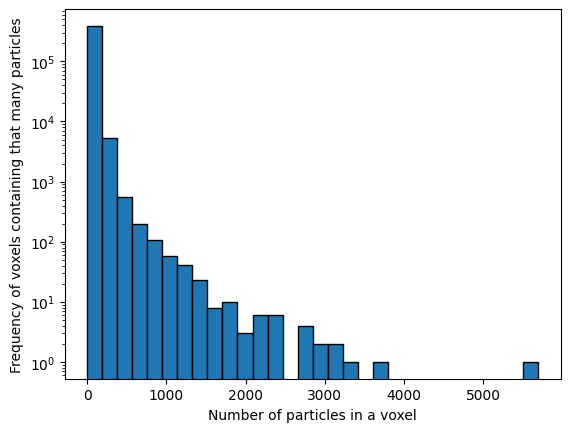

In [126]:
n, bins, patches = plt.hist(masses, bins=30, color="tab:blue", edgecolor="k")
# hist, bins = np.histogram(masses, bins=200)
plt.gca().set_yscale("log")
# print(n, bins)
# plt.xlim(0, 1000)
plt.xlabel("Number of particles in a voxel")
plt.ylabel("Frequency of voxels containing that many particles")
plt.savefig("hist.pdf")

In [128]:
n[0]

388990.0

In [129]:
395286-388990

6296